In [2]:
import pandas as pd
spam = pd.read_csv(r"C:\Users\justi\OneDrive\Documents\spam data.csv") 

In [3]:
!pip install keras
!pip install tensorflow

In [4]:
from sklearn.model_selection import train_test_split

y = spam['Category'].values
X = spam.drop(['Category'], axis = 1)

In [5]:
import numpy as np
import pandas as pd
from string import printable
st = set(printable)
data = pd.read_csv(r"C:\Users\justi\OneDrive\Documents\spam data.csv",names=["labelStr","text"],skiprows=1,usecols=[0,1],encoding="latin-1")

data["text"] = data["text"].apply(lambda x: ''.join(["" if  i not in st else i for i in x]))
data["label"]=data["labelStr"].apply(lambda x: 1 if x == "spam" else 0)

docs = data["text"].values
labels = data["label"].values

print(len(docs))

5572


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(vocab_size)
# pad documents to a max length of 4 words
max_length = 20
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(len(padded_docs))

8921
5572


In [7]:
embeddings_index = dict()
f = open(r"C:\Users\justi\OneDrive\Documents\glove.6B.100d.txt", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [8]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(8921, 100)


# Defining the ANN

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
# define the model

# Embedding layer has to come first and takes the embedding matrix and input_length arguments 
# A flattening layer (translates the outputs of the embedding into a vector of length 2,000: sequence length of 20 x embedding width of 100).
# Sigmoid output node to output probability estimate of class membership.

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=20, trainable=False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           892100    
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2001      
Total params: 894,101
Trainable params: 2,001
Non-trainable params: 892,100
_________________________________________________________________
None


In [11]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

NameError: name 'X_train' is not defined

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2, random_state=42)

In [36]:
model.fit(X_train, y_train, epochs=10, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 96.860987


In [13]:
#Try another model - CNN

from keras.preprocessing import sequence
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         892100    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 957,529
Trainable params: 957,529
Non-trainable params: 0
_________________________________________________________________


In [14]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [46]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9901


In [53]:
preds = model.predict(X_test)
from sklearn.metrics import confusion_matrix
import numpy as np

predicted_classes = np.argmax(preds, axis=1)

cm =confusion_matrix(y_test, predicted_classes)

cm[0][0] = 965
cm[0][1] = 9
cm[1][0] = 2
cm[1][1] = 139

cm


array([[965,   9],
       [  2, 139]], dtype=int64)

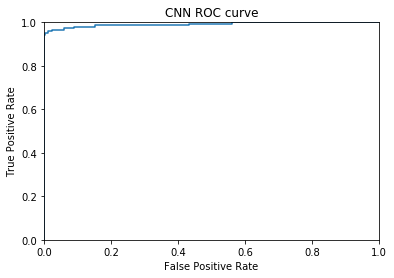

In [18]:
import matplotlib.pyplot as plt
y_val_cat_prob=model.predict_proba(X_test)

from sklearn.metrics import roc_curve,roc_auc_score



res = pd.get_dummies(y_test)

res[0]


fpr , tpr , thresholds = roc_curve ( res[1], y_val_cat_prob)

def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('CNN ROC curve')
    plt.show()

  
plot_roc_curve (fpr,tpr) 

In [55]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='CNN Word Embeddings Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[965   9]
 [  2 139]]


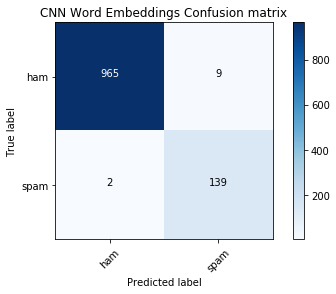

In [56]:
list = ['ham','spam']
plot_confusion_matrix(cm, list)

In [60]:
!pip install wordcloud

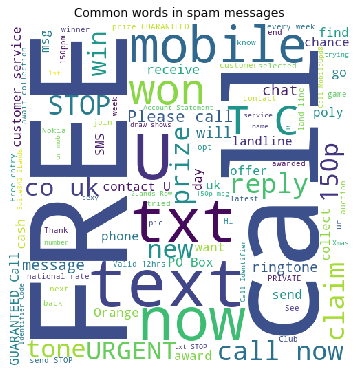

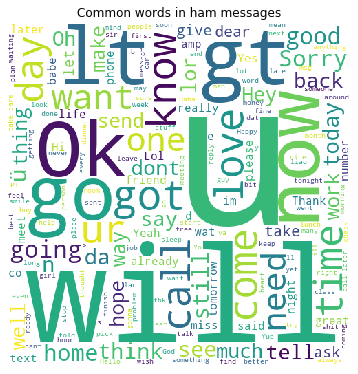

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the spam messages
spam1 = spam[spam['Category']=='spam']['Message'].str.cat(sep=', ')

# Get the ham messages
ham = spam[spam['Category']=='ham']['Message'].str.cat(sep=', ')

# Initialize he word cloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')

# Generate the world clouds for each type of message
spam_wc = wc.generate(spam1)

# plot the world cloud for spam                     
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(spam_wc) 
plt.axis("off") 
plt.title("Common words in spam messages")
plt.tight_layout(pad = 0) 
plt.show() 
ham_wc = wc.generate(ham)

# plot the world cloud for spam                       
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(ham_wc) 
plt.axis("off")
plt.title("Common words in ham messages")
plt.tight_layout(pad = 0) 
plt.show() 

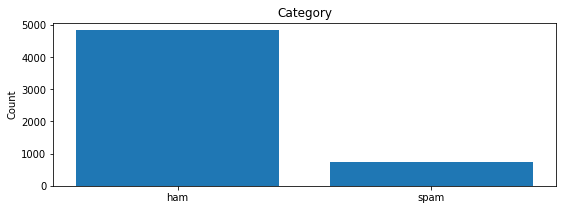

Category: 
ham     4825
spam     747
Name: Category, dtype: int64


In [68]:
var = spam['Category']
varValue = var.value_counts()

plt.figure(figsize=(9,3))
plt.bar(varValue.index, varValue)
plt.xticks(varValue.index,varValue.index.values)
plt.ylabel("Count")
plt.title('Category')
plt.show()
print("{}: \n{}".format('Category',varValue))